# Load Libs

In [1]:
import sys
sys.path.insert(0, '..')
from model.main import LISAModel
from model.utils import Patching_data

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy.signal import find_peaks

import argparse
class Nestedspace(argparse.Namespace):
    def __setattr__(self, name, value):
        if '.' in name:
            group, name = name.split('.', 1)
            ns = getattr(self, group, Nestedspace())
            setattr(ns, name, value)
            self.__dict__[group] = ns
        else:
            self.__dict__[name] = value

# Load Networks

In [44]:
!cp -r ../MF-CNN/data/* ../data/
# !mv ../output/z* ../output/result_50/

In [45]:
!ls ../data/

LDC2_sangria_mbhb-tdi_v1_MN5aIPz.h5  tc_list.npy
S_t.npy                              tdi_A_15s.npy
S_t_m.npy                            tdi_A_5s.npy
confusion_noise                      tdi_E_15s.npy
frequency.npy                        tdi_E_5s.npy
hh_sqrt_4096_50.npy                  template_St_matrix_z3_AE_4096_50.npy
information_15_mbhb.npy              template_data
psd.txt                              test_15_signal.npy
psd_16384_15s.npy                    test_LDC_16384_plus.npy
re_auc_list                          test_SNR
signal                               z_list.npy


In [46]:
!ls ../MF-CNN/

data  model


In [41]:
!ls ../output/result_50/

z1  z10 z15 z3  z6


In [40]:
!ls ../MF-CNN/model/result_50/

z1  z10 z15 z3  z6


In [2]:
# workplace = Path('../MF-CNN')
workplace = Path('../')
model_dir = workplace / 'output'
data_dir = workplace / 'data'

# init networks
lm = {}
for z in ['1', '3', '6', '10', '15']:
    lm[z] = LISAModel(model_dir=model_dir / 'result_50' / f'z{z}',
                   load_model_dir=model_dir / 'result_50' / f'z{z}',
                   data_dir=data_dir,
                   save_model_name=None,
                   load_model_name=f'model_test_z{z}.pt',
                   use_cuda=True)

In [3]:
# load inverse PSD
S_t_m12 = np.load(data_dir / 'S_t_m.npy')[np.newaxis, np.newaxis, ...]
S_t_m12 = torch.tensor(S_t_m12, dtype=torch.float32)  # [1, 1, 16384]

# load templates for MFCNN
template = np.load(data_dir / 'template_data' / 'template_St_matrix_z3_AE_4096_50.npy')
template = torch.tensor(template, dtype=torch.float32)  # (50, 2, 4096) [4096 x 15]sec

# load normalized terms for MFCNN
hh_sqrt = np.load(data_dir / 'template_data' / 'hh_sqrt_4096_50.npy')  # (50, 2)
hh_sqrt = torch.tensor(hh_sqrt, dtype=torch.float32)

In [4]:
# load networks trained on various redshifts
for z in ['1', '3', '6', '10', '15']:
    lm[z].init_model(template, hh_sqrt, S_t_m12)
    lm[z].load_model()

Load model from: ../output/result_50/z1/e99_model_test_z1.pt
Load model from: ../output/result_50/z3/e131_model_test_z3.pt
Load model from: ../output/result_50/z6/e134_model_test_z6.pt
Load model from: ../output/result_50/z10/e148_model_test_z10.pt
Load model from: ../output/result_50/z15/e91_model_test_z15.pt


# Load LDC2 / pre-processing / evaluation

- sampling rate: 15 Hz

In [5]:
tdi_A_15s = np.load(data_dir / 'tdi_A_15s.npy')
tdi_E_15s = np.load(data_dir / 'tdi_E_15s.npy')
tdi_15s = np.concatenate((tdi_A_15s[np.newaxis,...], tdi_E_15s[np.newaxis,...]))
print(f'A, E as two channels: {tdi_15s.shape}')

A, E as two channels: (2, 2102401)


- patching the 1 year data with window (16384/15) sec and overlap 80%.

In [6]:
p = Patching_data(patch_size=16384/15, overlap=0.8, sampling_frequency=15)
print(f'data shape: {p(tdi_15s).shape}')

	Patching with patch size=1092.2666666666667s and overlap=0.8%.
data shape: (2, 637, 16384)


In [7]:
tdi_15s_torch = torch.from_numpy(p(tdi_15s)).swapaxes(1,0)
print(f'as torch data structure: {tdi_15s_torch.shape}')

as torch data structure: torch.Size([637, 2, 16384])


- Evaluation (skipped)

In [8]:
# # Eval
# s = torch.nn.Softmax(dim=1)
# rho_z = {}
# pvalue_z = {}
# for z in ['1', '3', '6', '10', '15']:
#     if z != '6':
#         continue
#     pvalue = []
#     rho = []
#     with torch.no_grad():
#         lm[z].net.eval()
#         for i in tqdm(range(len(tdi_15s_torch) // batch_size)):
#             x = tdi_15s_torch[i*batch_size:(i+1)*batch_size]
#             out = lm[z].net(x.to(torch.float32).to(lm[z].device, non_blocking=True))
#             pvalue.extend(s(out)[:,0].numpy())
#             rho.extend(lm[z].net[:1](x.to(torch.float32).to(lm[z].device, non_blocking=True)).numpy())
#         else:
#             if len(tdi_15s_torch) % batch_size:
#                 x = tdi_15s_torch[-(len(tdi_15s_torch) % batch_size):]
#                 out = lm[z].net(x.to(torch.float32).to(lm[z].device, non_blocking=True))
#                 pvalue.extend(s(out)[:,0].numpy())
#     pvalue_z[z] = pvalue
#     rho_z[z] = rho
    
#     # # outdated
#     # d = np.asanyarray(rho_z[z])[l:r+1]          # (5, 50, 2, 16384)
#     # rho_max = np.max(np.abs(d), -1)           # 每个模板的最优 rho, (5, 50, 2)
#     # rho_max_time = np.argmax(np.abs(d), -1)   # 每个模板的最优时刻采样点, (5, 50, 2)
#     # rho_max_temp = np.argmax(rho_max, 1)      # 最佳模板的 index, (5, 2)    

- Load the stored results

In [9]:
# np.save('../temp_pvalue_z_overlap80', pvalue_z)
# np.savez('../temp_rho_z6_overlap80', rho_z)

pvalue_z = np.load('../temp_pvalue_z_overlap80.npy', allow_pickle=True).tolist()
# pvalue_z = np.load('../pvalue_z_overlap80.npy', allow_pickle=True).tolist()
pvalue_z.keys()

dict_keys(['6'])

# Load info of 15 MBHBs

In [10]:
u = np.load(data_dir / 'information_15_mbhb.npy')
df = pd.DataFrame({name: u[name][:,0] for name in u.dtype.names})
df.info()
df.sort_values('CoalescenceTime')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   EclipticLatitude        15 non-null     float64
 1   EclipticLongitude       15 non-null     float64
 2   PolarAngleOfSpin1       15 non-null     float64
 3   PolarAngleOfSpin2       15 non-null     float64
 4   Spin1                   15 non-null     float64
 5   Spin2                   15 non-null     float64
 6   Mass1                   15 non-null     float64
 7   Mass2                   15 non-null     float64
 8   CoalescenceTime         15 non-null     float64
 9   PhaseAtCoalescence      15 non-null     float64
 10  InitialPolarAngleL      15 non-null     float64
 11  InitialAzimuthalAngleL  15 non-null     float64
 12  Redshift                15 non-null     float64
 13  Distance                15 non-null     float64
 14  ObservationDuration     15 non-null     floa

,EclipticLatitude,EclipticLongitude,PolarAngleOfSpin1,PolarAngleOfSpin2,Spin1,Spin2,Mass1,Mass2,CoalescenceTime,PhaseAtCoalescence,InitialPolarAngleL,InitialAzimuthalAngleL,Redshift,Distance,ObservationDuration,Cadence
13,-0.564102,0.610927,0.908972,1.181699,0.972661,0.972862,1.015522e+06,7.968491e+05,4.800021e+06,4.275929,2.577539,4.094550,2.18186,17758.367941,3.155815e+07,3.0
6,-1.081082,4.052963,2.354232,1.689765,0.742128,0.989247,4.956676e+06,4.067167e+06,8.746488e+06,3.783309,0.963586,3.636925,6.17688,61097.116076,3.155815e+07,3.0
5,0.636028,0.779159,2.332027,2.065443,0.574122,0.592671,1.773563e+06,1.083356e+06,1.116784e+07,2.311127,0.232802,3.798411,6.03496,59472.237592,3.155815e+07,3.0
1,-0.878570,4.549720,2.068669,1.097989,0.942824,0.870789,9.159926e+05,7.017527e+05,1.125857e+07,1.150360,1.899782,5.829771,1.10396,7705.852640,3.155815e+07,3.0
0,-0.303004,1.292518,1.203136,2.097304,0.747377,0.838800,1.323277e+06,6.124855e+05,1.152694e+07,1.220197,2.691982,1.808398,1.73941,13470.983559,3.155815e+07,3.0
11,0.147296,5.986230,2.434152,1.926613,0.745574,0.546848,2.830218e+06,2.322253e+06,1.197096e+07,4.111379,1.131250,4.319761,5.50770,53474.693790,3.155815e+07,3.0
14,-0.987304,3.886726,2.594339,1.719446,0.829141,0.972219,3.204750e+06,3.056613e+06,1.361711e+07,3.628682,2.050928,1.084370,2.87966,24829.137775,3.155815e+07,3.0
2,0.917031,3.584892,1.665850,2.092903,0.988778,0.975945,1.856420e+06,1.801541e+06,1.653219e+07,1.866057,1.410068,0.527915,4.57261,43010.925050,3.155815e+07,3.0
7,0.835250,3.257316,2.362671,1.539846,0.833674,0.981901,3.983915e+06,2.049535e+06,1.724516e+07,1.578620,2.323179,3.643228,3.34910,29747.551597,3.155815e+07,3.0
4,-0.521369,3.085541,2.582941,2.200156,0.825883,0.811360,3.128823e+06,2.640346e+06,1.860576e+07,3.425317,2.604701,1.670016,7.21026,73048.167218,3.155815e+07,3.0


# Load raw LDC data

In [11]:
import h5py
addr = data_dir / 'LDC2_sangria_mbhb-tdi_v1_MN5aIPz.h5'
with h5py.File(addr, 'r') as h:
    X = np.asarray(h['X'])[:,1]
    Y = np.asarray(h['Y'])[:,1]
    Z = np.asarray(h['Z'])[:,1]

A = (Z - X) / np.sqrt(2)
E = (X-2*Y+Z)/np.sqrt(6)

# down-sampling
A = A[::3]
E = E[::3]

- Define the sample_times and `mid_time` for each predication

In [12]:
time = np.arange(0, 2102401*15, 15)
time = p(time[np.newaxis,...])[0]#.swapaxes(1,0)
mid_time = np.asarray([ (t[0] + (t[-1]-t[0])/2).tolist() for t in time ])
time.shape, len(mid_time)

((637, 16384), 637)

# Plot: 1-year LDC

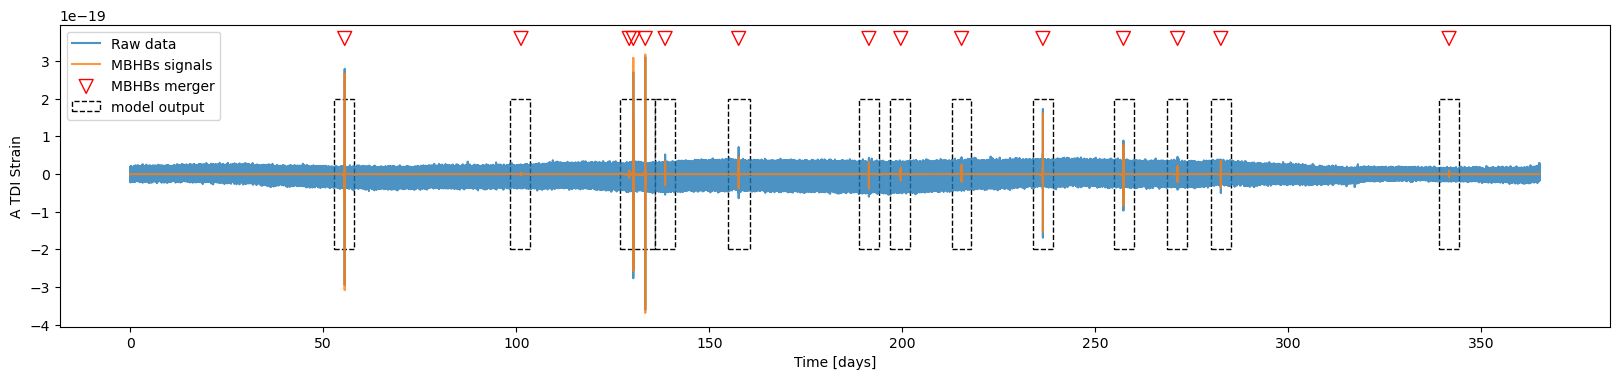

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

z = '6'
x = 1-np.asarray(pvalue_z[z])

# Find peaks
peaks, properties = find_peaks(x, plateau_size=5)

days = np.arange(0, 2102401*15, 15)/3600/24

alpha = 0.8
fig = plt.figure(figsize=(20,4), dpi=100)
ax = plt.subplot(111) #whole path
tdi = ax.plot(days, tdi_15s[0], alpha=alpha, label = 'Raw data')   # A
mbhbs = ax.plot(days, A, alpha=alpha, label='MBHBs signals')   # A
boxline = ax.bar(x=time[properties['left_edges']][:,0]/3600/24,
                  height=4e-19,
                  bottom=-2e-19,
                  width=time[properties['right_edges']][:,-1]/3600/24 - time[properties['left_edges']][:,0]/3600/24,
                  align='edge',
                  linestyle='--',
                  alpha=1,
                  edgecolor='k',
                  color='w',
                  label='model output'
    )
merger = ax.scatter(df['CoalescenceTime']/3600/24, [3.6e-19]*15, marker='v',
                    edgecolors='r', s=100, facecolors='none', label='MBHBs merger')
ax.legend(handles=[tdi[0], mbhbs[0], merger, boxline])
plt.ylabel('A TDI Strain');
plt.xlabel('Time [days]');

# Plot: 15 MBHBs pred.

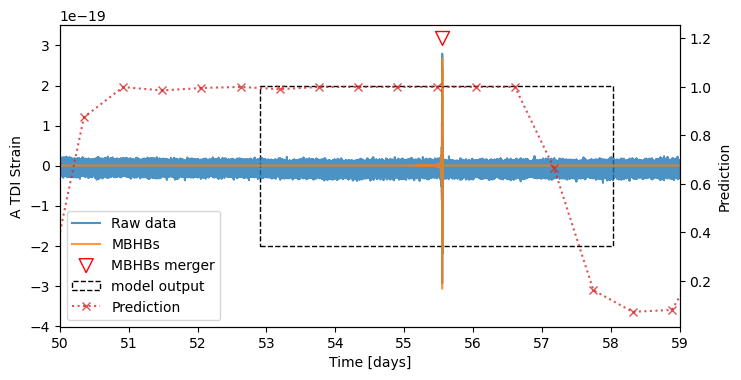

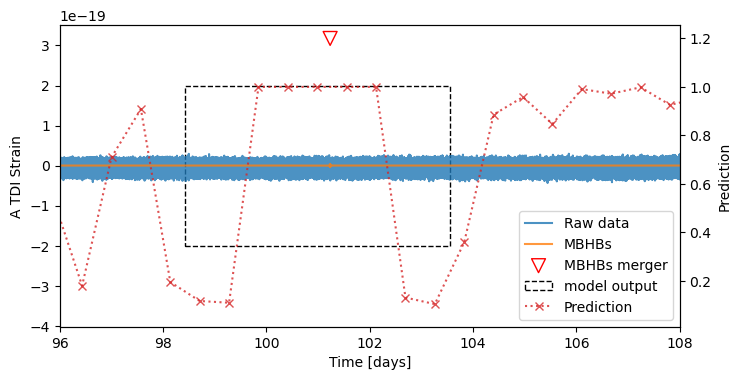

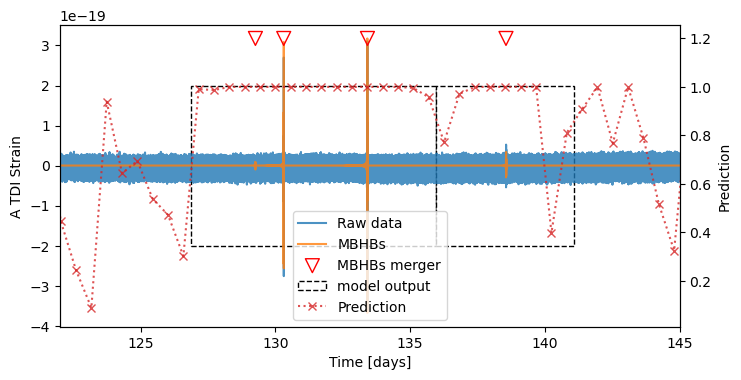

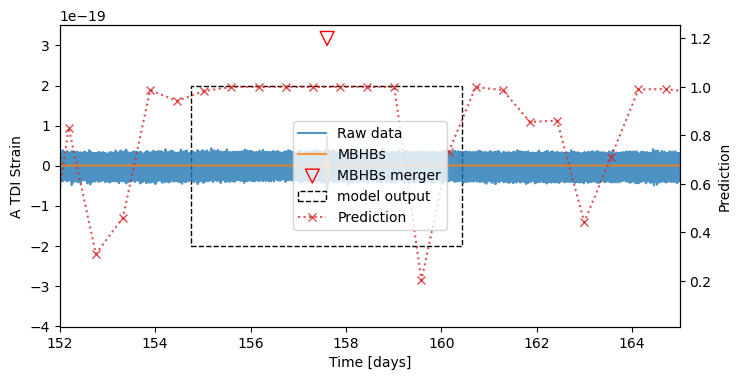

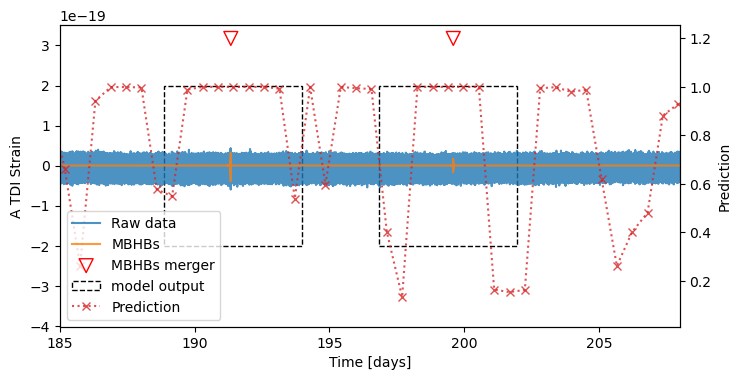

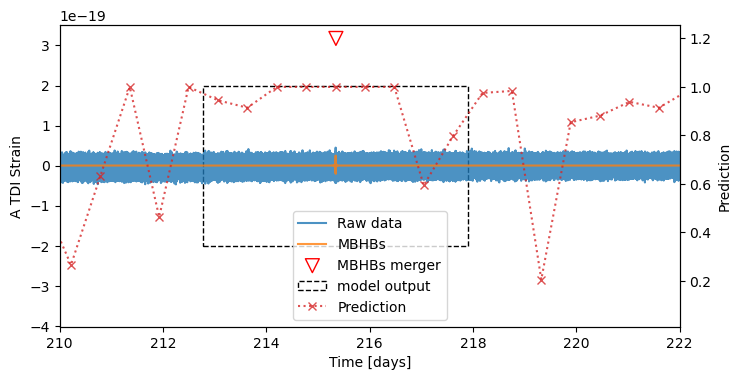

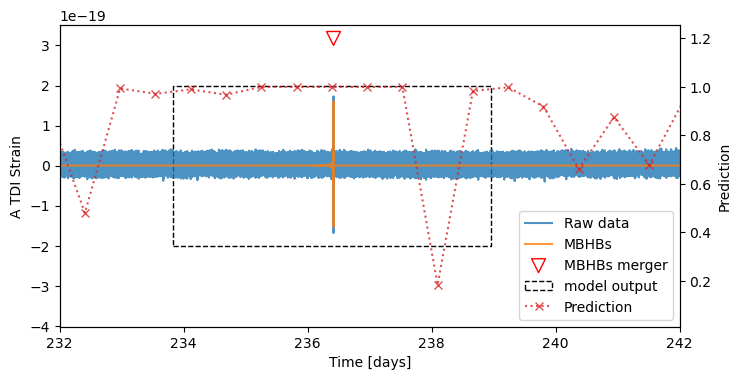

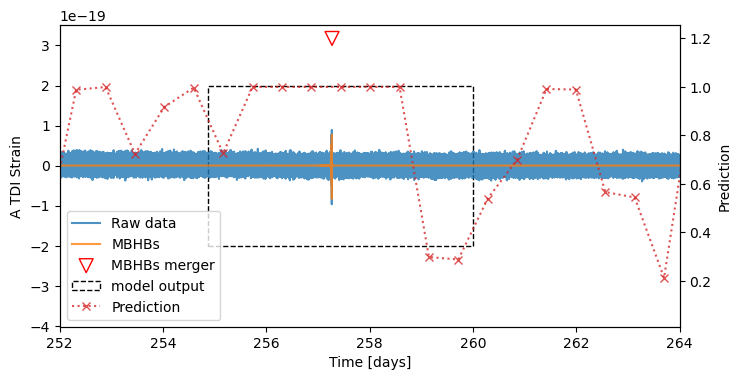

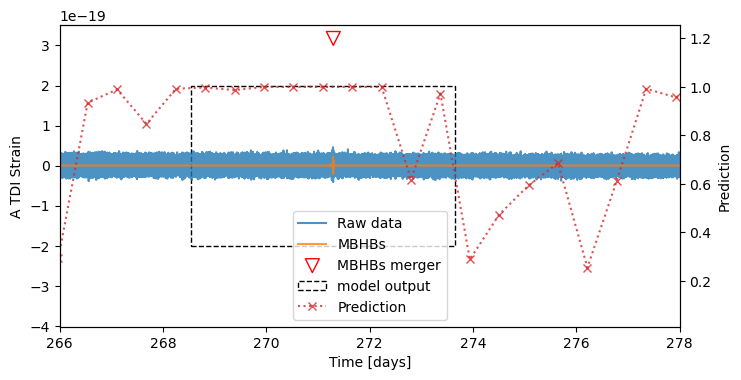

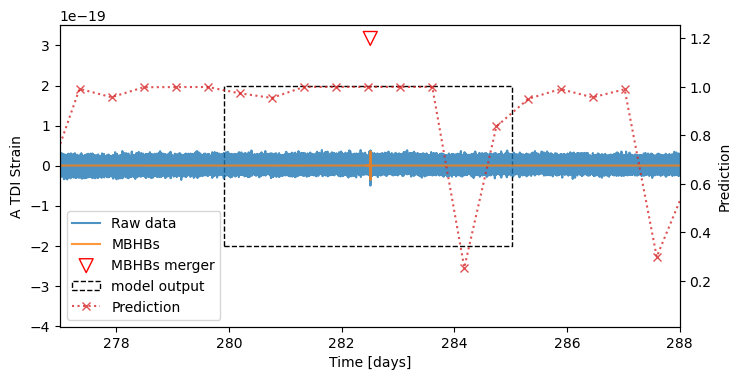

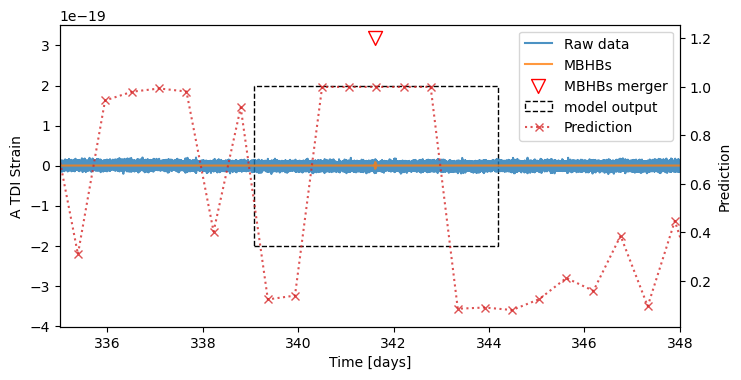

In [14]:
z = '6'
x = 1-np.asarray(pvalue_z[z])

peaks, properties = find_peaks(x, plateau_size=5)

alpha = 0.8
days = np.arange(0, 2102401*15, 15)/3600/24

xlim_list = [(50,59), (96, 108), (122,145), (152,165), (185,208),
             (210,222), (232,242), (252,264), (266,278),
             (277,288), (335,348)]
for xlim in xlim_list:

    fig = plt.figure(figsize=(8,4), dpi=100)
    ax = plt.subplot(111) #whole path
    tdi = ax.plot(days, tdi_15s[0], alpha=alpha, label = 'Raw data')   # A
    # plt.plot(days, tdi_15s[1], alpha=alpha) # E
    mbhbs = ax.plot(days, A, alpha=alpha, label='MBHBs')   # A
    boxline = ax.bar(x=time[properties['left_edges']][:,0]/3600/24,
                      height=4e-19,
                      bottom=-2e-19,
                      width=time[properties['right_edges']][:,-1]/3600/24 - time[properties['left_edges']][:,0]/3600/24,
                      linestyle='--',
                      align='edge',
                      alpha=1,
                      edgecolor='k',
                      color='w',
                      label='model output'
        )
    ax.set_xlim(*xlim)
    # ax.legend(handles=[mbhbs[0], boxline])
    plt.ylabel('A TDI Strain');
    plt.xlabel('Time [days]');

    ax2 = ax.twinx()
    pred = ax2.plot(mid_time/3600/24, x, label = 'Prediction', 
                    marker='x', alpha=alpha, linestyle=':', color='#d62728',
                    markeredgecolor='#d62728',)
    merger = ax2.scatter(df['CoalescenceTime']/3600/24, [1.2]*15, marker='v',
                    edgecolors='r', s=100, facecolors='none', label='MBHBs merger')
    plt.ylabel('Prediction');
    ax2.legend(handles=[tdi[0], mbhbs[0], merger, boxline, pred[0]], loc=0
              );

# Plot: sensitivity vs SNR

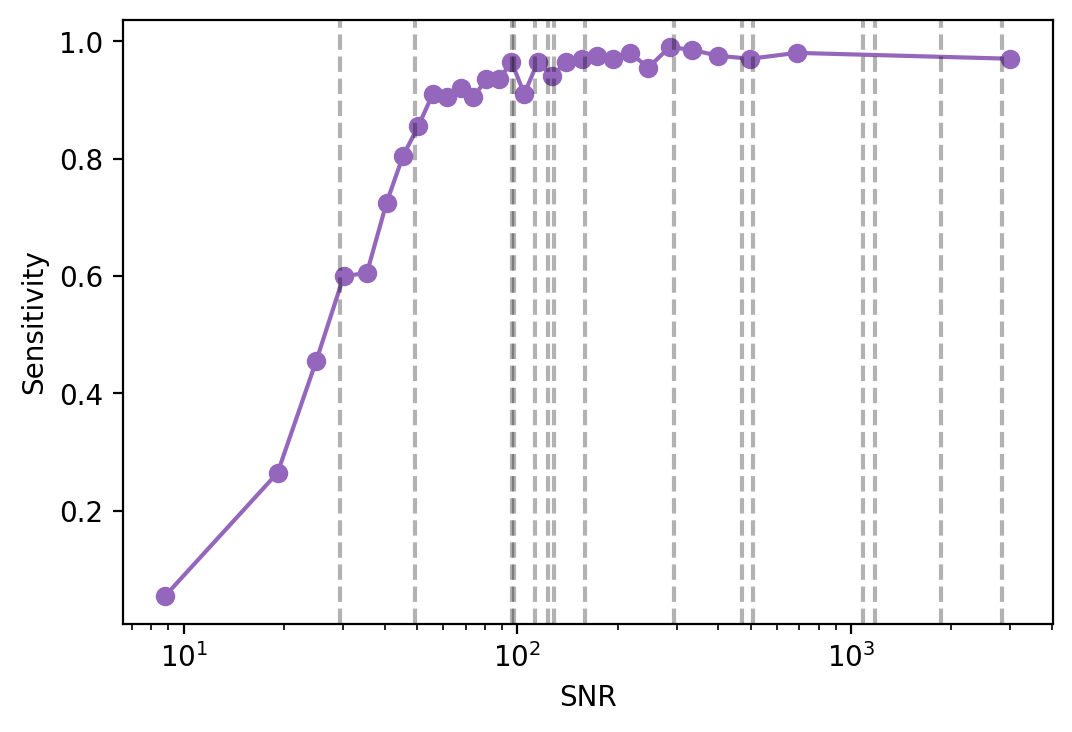

In [15]:
plt.figure(dpi=200)
sen_snr_xyv = np.load('../scripts/sen_snr_xyv.npy', allow_pickle=True).tolist()
plt.plot(sen_snr_xyv['xy'][0], sen_snr_xyv['xy'][1], marker='o', linestyle='-', color='#9467bd')
[plt.axvline(r, color='k', linestyle='--', alpha=0.3) for r in sen_snr_xyv['vline']];
plt.ylabel('Sensitivity')
plt.xlabel('SNR')
plt.xscale('log');

# Plot for publication

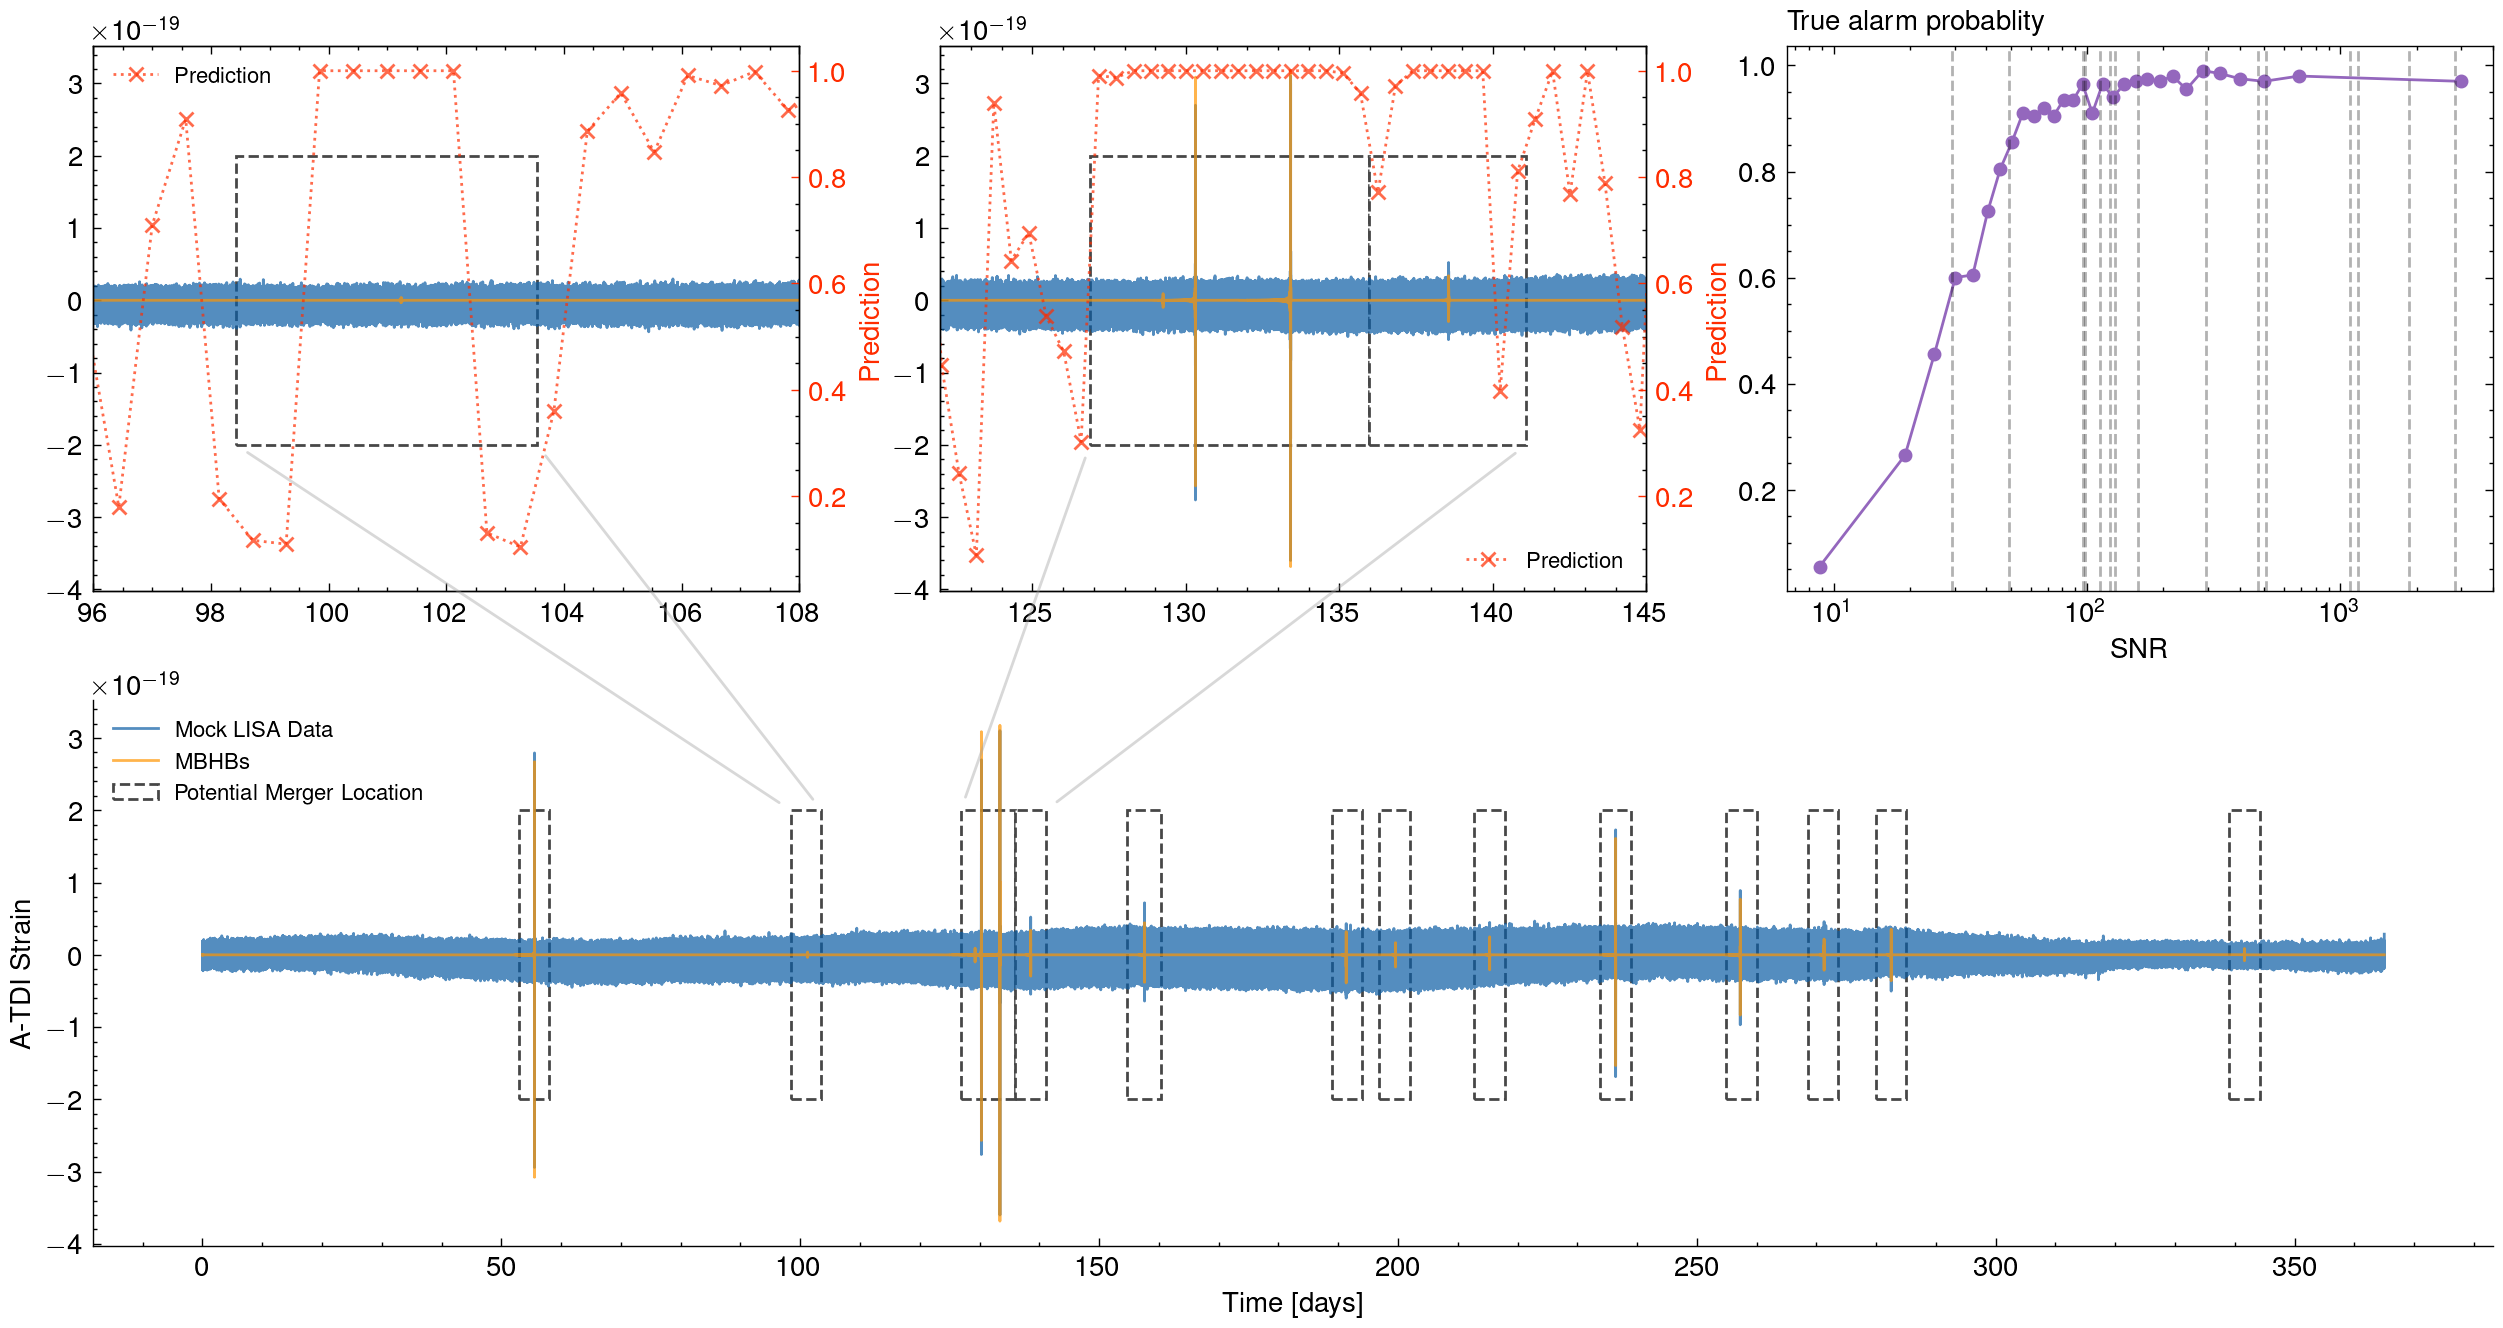

In [23]:
import numpy as np
from matplotlib.patches import ConnectionPatch 
import matplotlib.pyplot as plt

sen_snr_xyv = np.load('../scripts/sen_snr_xyv.npy', allow_pickle=True).tolist()
x = 1-np.asarray(pvalue_z['6'])

mid_time = np.asarray([ (t[0] + (t[-1]-t[0])/2).tolist() for t in time ])

xlim_list = [(50,59), (96, 108), (122,145), (152,165), (185,208),
             (210,222), (232,242), (252,264), (266,278),
             (277,288), (335,348.5)]

alpha = 0.7
days = np.arange(0, 2102401*15, 15)/3600/24

# with plt.style.context(['science', 'nature', #'high-vis'
#                        ]) :
plt.style.use(['science','nature'])
params = {
#         'text.usetex': False,
#           'figure.dpi': 200,
#               'font.size': 20,
#               'font.serif': [],
#               'font.sans-serif': [],
#               'font.monospace': [],
#               'axes.labelsize': 10,
#               'axes.titlesize': 10,
#               'axes.linewidth': 0.6,
    'legend.fontsize': 8.0,
    'axes.labelsize': 10.0,
#               'legend.fontsize': 10,
    'xtick.labelsize': 10.0,
     'ytick.labelsize': 10.0,
#           'font.family': 'serif',
#           'font.family': 'sans-serif',
         }
plt.rcParams.update(params)
# plt.rcParams.update({
# "font.family": "serif",   # specify font family here
# "font.serif": ["Times"],  # specify font here
# "font.size":10})          # specify font size here    
fig = plt.figure(figsize=(12, 6), dpi=200)
plt.subplots_adjust(bottom = 0., left = 0, top = 1., right = 1)

hb_list = [(4e-19, -2e-19), (4e-19, -2e-19), (0.6e-19, -0.3e-19)]
hb_list = [(4e-19, -2e-19), (4e-19, -2e-19), (4e-19, -2e-19)]
xlim_index = [1, 2, -1]
ylim_list = [(None, None), (None, None), (-0.5e-19, 0.5e-19)]
ylim_list = [(None, None), (None, None), (None, None)]
sub = {}
subx = {}
ds = 1

# https://towardsdatascience.com/5-powerful-tricks-to-visualize-your-data-with-matplotlib-16bc33747e05
for i, (height, bottom), xlim_i, ylim in zip(range(2), hb_list, xlim_index, ylim_list):

    sub[i] = fig.add_subplot(2,3,i+1) # two rows, two columns, second cell
    tdi = sub[i].plot(days[::ds], tdi_15s[0][::ds], alpha=alpha, label = 'Mock LISA Data', color='#0C5DA5')   # A
    mbhbs = sub[i].plot(days[::ds], A[::ds], alpha=alpha, label='MBHBs', color='#FF9500')   # A
    boxline = sub[i].bar(x=time[properties['left_edges']][:,0]/3600/24,
                      height=height,
                      bottom=bottom,
                      width=time[properties['right_edges']][:,-1]/3600/24 - time[properties['left_edges']][:,0]/3600/24,
                      linestyle='--',
                      align='edge',
                      alpha=1,
                      edgecolor='#474747',
                      color='w',
                      label='Potential Merger Location'
        )
    sub[i].set_xlim(*xlim_list[xlim_i])
    sub[i].set_ylim(*ylim)
    # ax.legend(handles=[mbhbs[0], boxline])
#     plt.ylabel('A-TDI Strain');
#     plt.xlabel('Time [days]');

    subx[i] = sub[i].twinx()
    pred = subx[i].plot(mid_time/3600/24, x, label = 'Prediction',  
                        marker='x', alpha=alpha, linestyle=':', 
                        color='#FF2C00',
                        markeredgecolor='#FF2C00', markersize=5,
                       ) 
    #https://www.cnblogs.com/Gelthin2017/p/14177100.html
    plt.ylabel('Prediction');
    subx[i].legend(handles=[#tdi[0], mbhbs[0], boxline, 
                            pred[0],], loc=0
              );
    subx[i].yaxis.label.set_color('#FF2C00')
    #subx[i].spines["right"].set_edgecolor('#d62728')
    subx[i].tick_params(axis='y', 
                        colors='#FF2C00'
                       )
# subx[2].legend(handles=[tdi[0], mbhbs[0], pred[0], boxline], loc=0
#           );

i = 2
sub[i] = fig.add_subplot(2,3,i+1) # two rows, two columns, second cell
sub[i].plot(sen_snr_xyv['xy'][0], sen_snr_xyv['xy'][1], marker='o', markersize=4, linestyle='-', color='#9467bd')
[sub[i].axvline(r, color='k', linestyle='--', alpha=0.3) for r in sen_snr_xyv['vline']];
# sub[i].set_ylabel('Sensitivity')
sub[i].set_title('True alarm probablity', fontsize=10, loc='left')
sub[i].set_xlabel('SNR')
sub[i].set_xscale('log');

ax = plt.subplot(2,3,(4,6)) # whole path
tdi = ax.plot(days[::ds], tdi_15s[0][::ds], alpha=alpha, label = 'Mock LISA Data', color='#0C5DA5')   # A
mbhbs = ax.plot(days[::ds], A[::ds], alpha=alpha, label='MBHBs', color='#FF9500')   # A
boxline = ax.bar(x=time[properties['left_edges']][:,0]/3600/24,
                  height=4e-19,
                  bottom=-2e-19,
                  width=time[properties['right_edges']][:,-1]/3600/24 - time[properties['left_edges']][:,0]/3600/24,
                  align='edge',
                  linestyle='--',
                  alpha=1,
                  edgecolor='#474747',
                  color='w',
                  label='Potential Merger Location'
    )
ax.legend(handles=[tdi[0], mbhbs[0], boxline], loc=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['right'].set_color('w')
# ax.spines['top'].set_color('w')
# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_ylabel('A-TDI Strain')
ax.set_xlabel('Time [days]')

shrinkA = 5
shrinkB = 5
color = '#9e9e9e'
alpha = 0.4
# https://vimsky.com/examples/usage/matplotlib-patches-connectionpatch-class-in-python.html
con1 = ConnectionPatch(xyA=(time[properties['left_edges']][1,0]/3600/24, -2e-19), coordsA=sub[0].transData, 
                       xyB=(time[properties['left_edges']][1,0]/3600/24, 2e-19), coordsB=ax.transData, 
                           color = color, 
                       shrinkB = shrinkB, shrinkA = shrinkA, alpha=alpha)
fig.add_artist(con1)

con1 = ConnectionPatch(xyA=(time[properties['right_edges']][1,-1]/3600/24, -2e-19), coordsA=sub[0].transData, 
                       xyB=(time[properties['right_edges']][1,-1]/3600/24, 2e-19), coordsB=ax.transData, 
                           color = color, 
                       shrinkB = shrinkB, shrinkA = shrinkA, alpha=alpha)
fig.add_artist(con1)


con1 = ConnectionPatch(xyA=(time[properties['left_edges']][2,0]/3600/24, -2e-19), coordsA=sub[1].transData, 
                       xyB=(time[properties['left_edges']][2,0]/3600/24, 2e-19), coordsB=ax.transData, 
                           color = color, 
                       shrinkB = shrinkB, shrinkA = shrinkA, alpha=alpha)
fig.add_artist(con1)

con1 = ConnectionPatch(xyA=(time[properties['right_edges']][3,-1]/3600/24, -2e-19), coordsA=sub[1].transData, 
                       xyB=(time[properties['right_edges']][3,-1]/3600/24, 2e-19), coordsB=ax.transData, 
                           color = color, 
                       shrinkB = shrinkB, shrinkA = shrinkA, alpha=alpha)
fig.add_artist(con1);


# plt.savefig('../scripts/LDC_test_v2.pdf', bbox_inches='tight', dpi=500);
# plt.savefig('../scripts/LDC_test_v2.png', bbox_inches='tight', dpi=500);